In [1]:
import os
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Cropping2D
from keras.layers import Lambda
from keras.optimizers import Adam
from keras.backend import tf as ktf
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.visualize_util import plot

CORRECTION = 0.2
mu, sigma = 0, 0.4

Using TensorFlow backend.


In [2]:
os.getcwd()

'/home/carnd/Behavioral-Cloning-Project'

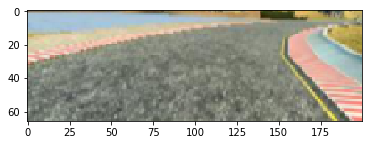

In [3]:
img_ex = cv2.imread('./Track1_Ashraf/IMG/center_2017_07_27_18_45_36_017.jpg')
img_ex = cv2.cvtColor(img_ex, cv2.COLOR_BGR2RGB)
img_ex = cv2.GaussianBlur(img_ex, (3,3), 0)
crop_ex = img_ex[62:138,:,:]

import tensorflow as tf
crop_tf = np.expand_dims(crop_ex, axis=0)
crop_tf = tf.constant(crop_tf)
crop_tf_resize = tf.image.resize_nearest_neighbor(crop_tf, (66,200))

crop_tf_ex = crop_tf_resize.eval(session=tf.Session())

plt.imshow(crop_tf_ex[0])
plt.imsave('img_resized.png', crop_tf_ex[0])
# plt.savefig('blur_ex.png')
# plt.imsave('blur_track1.png', last)
plt.show()

In [4]:
## Import all data collected from Data Directories which Includes my own and Udacity's Dataset
DIR_NAMES = ['Track1_Ashraf_Recovery/', 'Track2_Ashraf/', 'Track1_Ashraf/', 'data/']
data = []

for directory in DIR_NAMES:
    file_name = './' + directory + 'driving_log.csv'
    with open(file_name, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            row[0] = ('./' + directory + row[0][row[0].find('IMG'):]).replace(' ','')
            row[1] = ('./' + directory + row[1][row[1].find('IMG'):]).replace(' ','')
            row[2] = ('./' + directory + row[2][row[2].find('IMG'):]).replace(' ','')
            row[3] = float(row[3])
            data.append(row)

print('Number of Images Imported: {}'.format(len(data)))

Number of Images Imported: 23926


Determined Maximum Density = 1560 images/bin


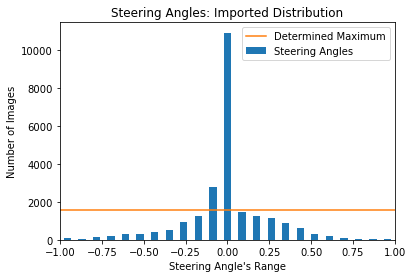

Over Flowing Bins # 10
Over Flowing Bins # 11


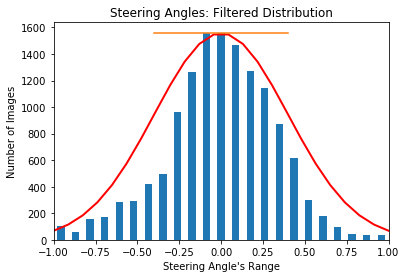

Number of Images after filtering: 13396 image


In [5]:
##Visualizing Distribution and Variance of the Imported DataSet's Steering Angle

steering = []
data_filtered = []

for row in data:
    data_filtered.append(row[:4])
    ang = row[3]
    steering.append(ang)        #Center

angles = np.array(steering)
hist, bins = np.histogram(angles, bins=23)

average = int(hist.mean() * 1.5)
print('Determined Maximum Density = {} images/bin'.format(average))

##Plot a Histogram Using MatPlotLib of Imported Data
npsteer = np.array(steering)
plt.figure(1)
plt.hist(npsteer, bins=23, rwidth=0.5)
plt.plot([-1,1],[average,average])
plt.title('Steering Angles: Imported Distribution')
plt.legend(['Determined Maximum','Steering Angles'])
plt.xlim(-1.,1.)
plt.xlabel('Steering Angle\'s Range')
plt.ylabel('Number of Images')
plt.savefig('import_data_dist.png')
plt.show()

##Filter the data to be below the determined maximum
steer_filter = steering
image_filter = data_filtered

for i in range(len(bins)-1):
    remove_list = []
    # Only filter the bins above the Maximum
    if hist[i] > average:
        print('Over Flowing Bins #', i)
        for j in range(len(steer_filter)):
            if steer_filter[j] < bins[i+1] and steer_filter[j] >= bins[i]:
                #Create a list of indices withholding the entire overflowing bin
                remove_list.append(j)
        
        #Randomly Shuffle through the Indices
        np.random.shuffle(remove_list)
        #Keep only an amount equal to the determined maximum from the shuffled data (Steering Angles + Images)
        remove = remove_list[:-average]
        steer_filter = np.delete(steer_filter, remove)
        data_filtered = np.delete(data_filtered, remove, axis=0).tolist()

## Plot a Histogram Representing the filtered data
plt.figure(2)
plt.hist(steer_filter, bins=23, rwidth=0.5)
bell_curve = average/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) )
plt.plot(bins, bell_curve, linewidth=2, color='r')
plt.plot([-0.4,0.4],[average,average])
plt.title('Steering Angles: Filtered Distribution')
plt.xlim(-1.,1.)
plt.xlabel('Steering Angle\'s Range')
plt.ylabel('Number of Images')
plt.savefig('filter_data_dist.png')
plt.show()        
print('Number of Images after filtering: {} image'.format(len(data_filtered)))

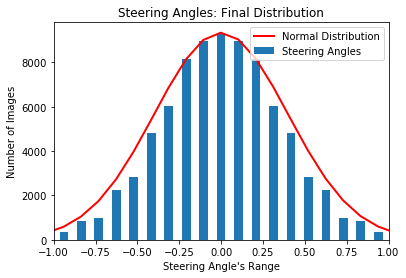

Number of Images after filtering: 80376 image


In [6]:
steering_filtered = []

for row in data_filtered:
    #Adjust new filtered data by changing steering angles from string to float
    row[3] = float(row[3])
    #Visualize the data after using the Left and Right Cameras and Flipping
    ## Increase the data set by a factor x6
    ang = row[3]
    steering_filtered.append(ang)        #Center
    steering_filtered.append(ang+CORRECTION)  #Left
    steering_filtered.append((ang-CORRECTION))  #Right
    steering_filtered.append(-ang)       #Center Flip
    steering_filtered.append(-(ang+CORRECTION)) #Left Flip
    steering_filtered.append(-(ang-CORRECTION)) #Right Flip


plt.figure()
plt.hist(steering_filtered, bins=23, rwidth=0.5)

plt_hist, plt_bins = np.histogram(steering_filtered, bins=23)
plt_bins = (plt_bins+0.05)[:-1]
aug_average = average*6
aug_bell_curve = aug_average/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (plt_bins - mu)**2 / (2 * sigma**2) )
plt.plot(plt_bins, aug_bell_curve,linewidth=2, color='r')

plt.title('Steering Angles: Final Distribution')
plt.xlabel('Steering Angle\'s Range')
plt.xlim(-1.,1.)
plt.ylabel('Number of Images')
plt.legend(['Normal Distribution','Steering Angles'])
plt.savefig('normalized_data_dist.png')

plt.show()

print('Number of Images after filtering: {} image'.format(len(steering_filtered)))

In [7]:
##Split the filtered data to training and validation sets

train_data, valid_data = train_test_split(data_filtered, test_size=0.2)

n_train = len(train_data)
n_valid = len(valid_data)

print('Training Data: {}'.format(n_train))
print('Validation Data: {}'.format(n_valid))

Training Data: 10716
Validation Data: 2680


In [8]:
##IMAGE Class defined assign a correct angle to each image and augment it

class IMAGE(object):
    def __init__(self, image=np.array([]), angle=None, LEFT=False, RIGHT=False, CORRECTION=CORRECTION):
        self.image = image
        self.angle = angle

        if LEFT:
            self.angle += CORRECTION

        if RIGHT:
            self.angle -= CORRECTION
    
    ##Change image format from BGR to RGB since drive.py is using RGB images, 
    ##while cv2.imread reads an image in BGR format
    def rgb(self):
        rgb_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        return IMAGE(image=rgb_image, angle=self.angle)

#     def yuv(self):
#         yuv_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2YUV)
#         return IMAGE(image=yuv_image, angle=self.angle)
    
    ##Apply Gaussian Blur to every image with kernel size 3x3 to reduce texture
    def blur(self):
        blur_image = cv2.GaussianBlur(self.image,(3,3), 0)
        return IMAGE(image=blur_image, angle=self.angle)
    
    ##Flip function to flip each image and negate its angle
    def flip(self):
        image = cv2.flip(self.image, 1)
        angle = -self.angle
        return IMAGE(image=image, angle=angle)
    
    ##Apply a random brightness to each image either brighten or dim randomly 
    ##to further regularize the training data (Account for shadows)
    def random_bright(self):
        beta = random.randint(-50,50+1)
        bright_img = np.zeros_like(self.image)
        bright_img = cv2.convertScaleAbs(self.image, bright_img, 1., beta)
        return IMAGE(image=bright_img, angle=self.angle)

In [9]:
## A python generator importing images from filtered dataset as IMAGE

## The generator uses all Left, Center and Right images and accordingly
## generate steering angles accordingly per image

def img_generator(csv_data, batch_size=32, correction=CORRECTION):
    
    while 1:
        shuffle(csv_data)
        
        for start_i in range(0,len(csv_data), batch_size):
            end_i = start_i + batch_size
            batch = csv_data[start_i:end_i]
            
            center_imgs = []
            steer_angles = []
            
            for example in batch:
                ## CENTER IMAGE
                image_C = IMAGE(image=cv2.imread(example[0]), angle=example[3]).rgb().blur()
                
                center_imgs.append(image_C.random_bright().image)
                steer_angles.append(image_C.angle)
                
                ## FLIPPED CENTER IMAGE
                image_C_flip = image_C.flip().random_bright()
                center_imgs.append(image_C_flip.image)
                steer_angles.append(image_C_flip.angle)
                
                
                ## LEFT IMAGE
                image_L = IMAGE(image=cv2.imread(example[1]), angle=example[3], LEFT=True, 
                                                              CORRECTION=correction).rgb().blur()

                center_imgs.append(image_L.random_bright().image)
                steer_angles.append(image_L.angle)
                
                ## FLIPPED LEFT IMAGE
                image_L_flip = image_L.flip().random_bright()
                center_imgs.append(image_L_flip.image)
                steer_angles.append(image_L_flip.angle)
                
                
                ## RIGHT IMAGE
                image_R = IMAGE(image=cv2.imread(example[2]), angle=example[3], RIGHT=True, 
                                                              CORRECTION=correction).rgb().blur()

                center_imgs.append(image_R.random_bright().image)
                steer_angles.append(image_R.angle)
                
                ## FLIPPED RIGHT IMAGE
                image_R_flip = image_R.flip().random_bright()
                center_imgs.append(image_R_flip.image)
                steer_angles.append(image_R_flip.angle)
            
            
            X_batch = np.array(center_imgs)
            y_batch = np.array(steer_angles)
            
            yield shuffle(X_batch, y_batch)

In [10]:
## Function used in the Model for resizing each input image to 66x200x3
def resize(x):
    from keras.backend import tf as ktf
    return ktf.image.resize_nearest_neighbor(x , (66, 200))

In [11]:
### NVIDIA ARCHITECTURE
model_NVIDIA = Sequential()

##First Section of Model to Preprocess input Images: 3 Lambda Layers
#Cropping Layer
model_NVIDIA.add(Cropping2D(cropping=((62,22),(0,0)), input_shape=(160,320,3)))
#Resize Layer
model_NVIDIA.add(Lambda(resize))
#Normalization Layer
model_NVIDIA.add(Lambda(lambda x: ((x / 255.) - 0.5)*2.)) # -1 to 1

## Convolutions
#Convolutional Layer 1: 24, 5x5 Filters, ELU Activation, 2x2 Max Pooling
model_NVIDIA.add(Conv2D(24, 5, 5, border_mode='same', W_regularizer=l2(0.001)))
model_NVIDIA.add(BatchNormalization())
model_NVIDIA.add(Activation('elu'))
model_NVIDIA.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional Layer 2: 36, 5x5 Filters, ELU Activation, 2x2 Max Pooling
model_NVIDIA.add(Conv2D(36, 5, 5, border_mode='same', W_regularizer=l2(0.001)))
model_NVIDIA.add(BatchNormalization())
model_NVIDIA.add(Activation('elu'))
model_NVIDIA.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional Layer 3: 48, 5x5 Filters, ELU Activation, 2x2 Max Pooling
model_NVIDIA.add(Conv2D(48, 5, 5, border_mode='same', W_regularizer=l2(0.001)))
model_NVIDIA.add(BatchNormalization())
model_NVIDIA.add(Activation('elu'))
model_NVIDIA.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional Layer 4: 64, 3x3 Filters, ELU Activation, 2x2 Max Pooling
model_NVIDIA.add(Conv2D(64, 3, 3, border_mode='same', W_regularizer=l2(0.001)))
model_NVIDIA.add(BatchNormalization())
model_NVIDIA.add(Activation('elu'))
model_NVIDIA.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional Layer 5: 64, 3x3 Filters, ELU Activation, 2x2 Max Pooling
model_NVIDIA.add(Conv2D(64, 3, 3, border_mode='same', W_regularizer=l2(0.001)))
model_NVIDIA.add(BatchNormalization())
model_NVIDIA.add(Activation('elu'))
model_NVIDIA.add(MaxPooling2D(pool_size=(2,2)))

#Flatten Layer to apply Fully Connected Layers
model_NVIDIA.add(Flatten())

##Fully Connected Layers
#Dense Layer 1: Output 100 node, ELU Activation
model_NVIDIA.add(Dense(100, W_regularizer=l2(0.001)))
model_NVIDIA.add(BatchNormalization())
model_NVIDIA.add(Activation('elu'))
# model_NVIDIA.add(Dropout(0.8))  #?

#Dense Layer 2: Output 50 node, ELU Activation
model_NVIDIA.add(Dense(50, W_regularizer=l2(0.001)))
model_NVIDIA.add(BatchNormalization())
model_NVIDIA.add(Activation('elu'))
# model_NVIDIA.add(Dropout(0.8))  #?

#Dense Layer 3: Output 10 node, ELU Activation
model_NVIDIA.add(Dense(10, W_regularizer=l2(0.001)))
model_NVIDIA.add(BatchNormalization())
model_NVIDIA.add(Activation('elu'))
# model_NVIDIA.add(Dropout(0.8))  #?

##Output Layer: Predicted Steering Angle
model_NVIDIA.add(Dense(1))

##Adam Optimizer for the Model
adam = Adam(lr=0.001) #0.001

##Compile Model: Loss Function - Mean Squared Error
##               Optimizer - Adam

model_NVIDIA.compile(loss='mse', optimizer= adam)
# model_NVIDIA.summary()

In [12]:
## Keras Callback Functions
# EarlyStop monitors the Validation Loss and terminates training once it stops decreasing
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0)

# Checkpoints, save the model every epoch only when the validation loss decreases
checkpoint = ModelCheckpoint(filepath='model.h5',mode='auto',monitor='val_loss',period=1,save_best_only=True)

In [13]:
## Use the python generator for training and validation datasets with batch size = 16
train_generator = img_generator(train_data, batch_size=16)
valid_generator = img_generator(valid_data, batch_size=16)

## Train the model using the train and validation generators with earlystopping
NVIDIA_history = model_NVIDIA.fit_generator(train_generator, nb_epoch=50, samples_per_epoch=n_train*6,
                    validation_data=valid_generator, nb_val_samples=n_valid*6,
                    callbacks= [checkpoint, earlystop])

Epoch 1/50
64296/64296 [==============================] - 328s - loss: 0.4422 - val_loss: 0.2952
Epoch 2/50
64296/64296 [==============================] - 321s - loss: 0.2117 - val_loss: 0.1493
Epoch 3/50
64296/64296 [==============================] - 321s - loss: 0.1117 - val_loss: 0.0886
Epoch 4/50
64296/64296 [==============================] - 321s - loss: 0.0712 - val_loss: 0.0720
Epoch 5/50
64296/64296 [==============================] - 321s - loss: 0.0554 - val_loss: 0.0537
Epoch 6/50
64296/64296 [==============================] - 321s - loss: 0.0497 - val_loss: 0.0569


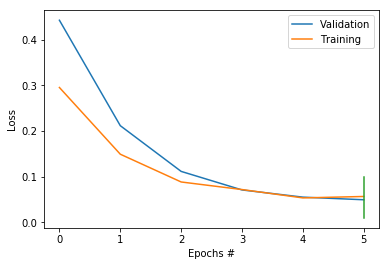

In [16]:
## Use Keras Visualizing Utilities to Plot the model's Architecture
plot(model_NVIDIA, to_file='model.png', show_shapes=True, show_layer_names=False)

## Plot the model's history showing the Training and Validation Losses
hist = NVIDIA_history.history
plt.figure()
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.xlabel('Epochs #')
plt.ylabel('Loss')
plt.legend(['Validation', 'Training'])
plt.plot([5,5],[0.01,0.1])
plt.savefig('model_loss.png')
plt.show()